In [1]:
import pennylane as qml
import pennylane.numpy as np
import jax.numpy as jnp
from scipy.special import legendre
import jax
import optax

from time import time
import pickle

import matplotlib.pyplot as plt


import os, sys, argparse

parent = os.path.abspath('../src')
sys.path.insert(1, parent)

from perceptron import Perceptron



# Set to float64 precision and remove jax CPU/GPU warning
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")


In [2]:

def get_loss_function(perceptron, ts, H_obj, dev):

    @jax.jit
    @qml.qnode(dev, interface="jax")
    def loss(param_vector):

        # hamitlonian_params = dictionary_to_hamiltonian_parameters(params_dict)

        param_list = perceptron.vector_to_hamiltonian_parameters(param_vector)

        qml.evolve(perceptron.H)(param_list, ts)

        return qml.expval(H_obj)

    return loss


In [3]:

# setting up the problem
perceptron_qubits = 3
fourier_basis = 2
ts = jnp.array([0.0, 1.0])

dev = qml.device("default.qubit.jax", wires = perceptron_qubits)


perceptron = Perceptron(perceptron_qubits, fourier_basis, basis='gaussian', pulse_width=0.5e-2)

H =  perceptron.H

H_obj, H_obj_spectrum = perceptron.get_1d_ising_hamiltonian(0.1)

e_ground_state_exact = H_obj_spectrum[0]

print(f'Ising Model Hamiltonian:\nH = {H_obj}')
print(f'Exact ground state energy: {e_ground_state_exact}')
    



Ising Model Hamiltonian:
H =   (0.1) [X0]
+ (0.1) [X1]
+ (0.1) [X2]
+ (1.0) [Z0 Z1]
+ (1.0) [Z1 Z2]
Exact ground state energy: -2.013499645210101


I0000 00:00:1699828984.540081       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
/Users/jorgegarciaponce/Research/Yelin/PerceptronLossLandscapes/.venv/lib/python3.11/site-packages/pennylane/ops/functions/eigvals.py:108: UserWarning: For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires. Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.
  warnings.warn(


In [4]:
# getting the loss_function
loss = get_loss_function(perceptron, ts, H_obj, dev)

param_vector = perceptron.get_random_parameter_vector(0)

print(f'Initial parameters: {param_vector}')

print(f'Initial loss: {loss(param_vector)}')

initial_gradients = jax.grad(loss)(param_vector)
print(f'Initial gradients: {initial_gradients}')

value_and_grad = jax.jit(jax.value_and_grad(loss))

Initial parameters: [0.60201461 0.40051449 0.41383077 0.02308874 0.48543894 0.23168584
 0.37351903 0.00688964 0.70342219 0.26233539 0.55531044 0.63519432
 0.20343135 0.8801997 ]
Initial loss: 0.9494727015300507
Initial gradients: [-0.18886243 -0.10565445  0.36586594  0.33211249  0.0395079   0.52621094
 -0.79220887  0.52302653  0.8577132   1.27930715  0.52601528  0.57590492
  0.98644147  1.10637245]


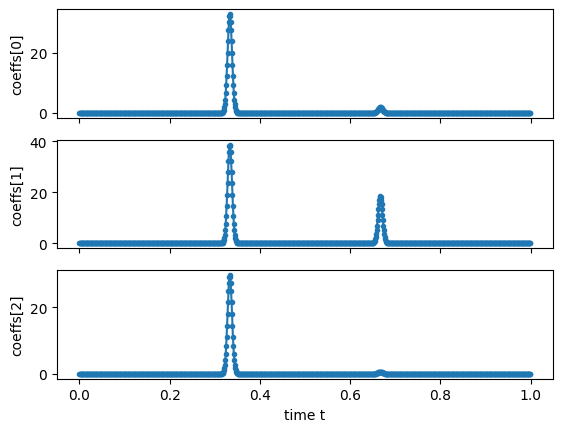

In [5]:
ts = jnp.linspace(0.0, 1, 1000)[:-1]

param_list = perceptron.vector_to_hamiltonian_parameters(param_vector)

fig, axs = plt.subplots(nrows=perceptron_qubits, sharex=True)
for i in range(perceptron_qubits):
    ax = axs[i]
    ax.plot(ts, perceptron.control_fields[i](param_list[i+perceptron_qubits-1], ts), ".-")
    ax.set_ylabel(f"coeffs[{i}]")
ax.set_xlabel("time t")
plt.show()


In [6]:

from datetime import datetime

n_epochs = 100
param_vector = perceptron.get_random_parameter_vector(0)

# The following block creates a constant schedule of the learning rate
# that increases from 0.1 to 0.5 after 10 epochs
# schedule0 = optax.constant_schedule(1e-1)
# schedule1 = optax.constant_schedule(5e-1)
# schedule = optax.join_schedules([schedule0, schedule1], [20])
# optimizer = optax.adam(learning_rate=schedule)
optimizer = optax.adam(learning_rate=1)
opt_state = optimizer.init(param_vector)

energy = np.zeros(n_epochs + 1)
energy[0] = loss(param_vector)
mean_gradients = np.zeros(n_epochs)
param_trajectory = []

## Compile the evaluation and gradient function and report compilation time
time0 = datetime.now()
_ = value_and_grad(param_vector)
time1 = datetime.now()
print(f"grad and val compilation time: {time1 - time0}")


## Optimization loop
for n in range(n_epochs):
    val, grads = value_and_grad(param_vector)
    updates, opt_state = optimizer.update(grads, opt_state)
    param_vector = optax.apply_updates(param_vector, updates)

    mean_gradients[n] = np.mean(np.abs(grads))
    energy[n+1] = val

    # print(f"            param: {param_vector}")

    if not n % 10:
        print(f"{n+1} / {n_epochs}; energy discrepancy: {val-e_ground_state_exact}")
        print(f"mean grad: {mean_gradients[n]}")



print(f"Found ground state: {energy[-1]}")


grad and val compilation time: 0:00:03.922806
1 / 100; energy discrepancy: 2.9629723467401514
mean grad: 0.5860860017545413
11 / 100; energy discrepancy: 1.7367651634321897
mean grad: 0.26968736421275447
21 / 100; energy discrepancy: 0.13660152332029263
mean grad: 0.23052268966412193
31 / 100; energy discrepancy: 0.23455418269095563
mean grad: 0.28756929758872174
41 / 100; energy discrepancy: 0.07161075829713881
mean grad: 0.11681025189124984
51 / 100; energy discrepancy: 0.023700095526539844
mean grad: 0.07537401465240244
61 / 100; energy discrepancy: 0.008569146486075763
mean grad: 0.032065711221611955
71 / 100; energy discrepancy: 0.005483739028784296
mean grad: 0.021466199555816006
81 / 100; energy discrepancy: 0.0035550885640649454
mean grad: 0.012726159786513433
91 / 100; energy discrepancy: 0.0023355421673123544
mean grad: 0.011597452120894008
Found ground state: -2.011819359104118


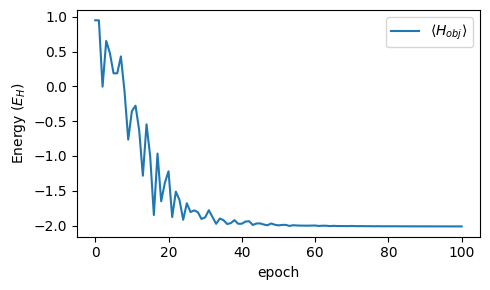

In [7]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

y = energy 
ax.plot(y, label="$\\langle H_{{obj}}\\rangle$")
# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle$")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
# ax.set_yscale("log")
ax.set_ylabel("Energy ($E_H$)")
ax.set_xlabel("epoch")
ax.legend()

plt.tight_layout()
plt.show()

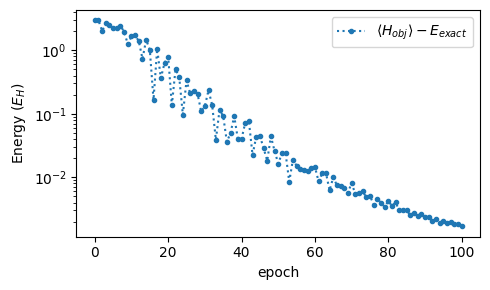

In [8]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

y = energy - e_ground_state_exact
ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
ax.set_yscale("log")
ax.set_ylabel("Energy ($E_H$)")
ax.set_xlabel("epoch")
ax.legend()

plt.tight_layout()
plt.show()

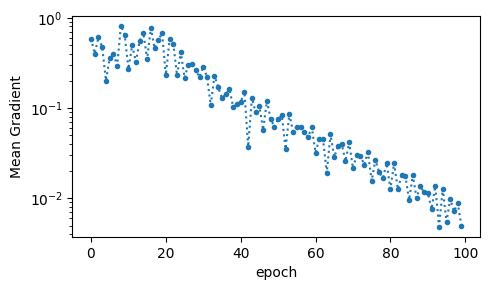

In [9]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

# y = np.array(energy) - e_ground_state_exact
y = mean_gradients
# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
ax.plot(y, ".:")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
ax.set_yscale("log")
ax.set_ylabel("Mean Gradient")
ax.set_xlabel("epoch")
# ax.legend()

plt.tight_layout()
plt.show()

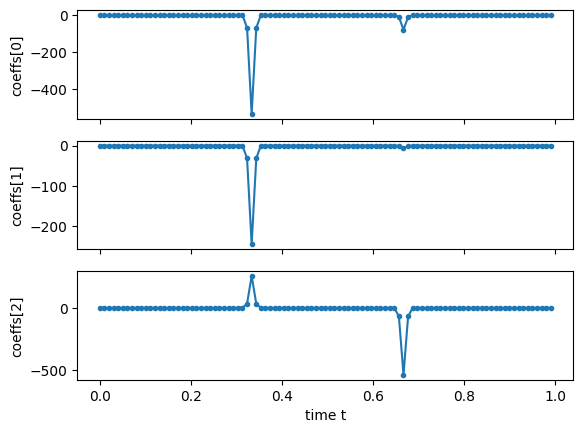

In [11]:
ts = jnp.linspace(0.0, 1, 100)[:-1]

param_list = perceptron.vector_to_hamiltonian_parameters(param_vector)

fig, axs = plt.subplots(nrows=perceptron_qubits, sharex=True)
for i in range(perceptron_qubits):
    ax = axs[i]
    ax.plot(ts, perceptron.control_fields[i](param_list[i+perceptron_qubits-1], ts), ".-")
    ax.set_ylabel(f"coeffs[{i}]")
ax.set_xlabel("time t")
plt.show()

In [12]:
# Calculating the Final Hessian

final_hessian = jax.jacrev(jax.jacrev(loss))(param_vector)
final_hessian_eigenvalues = jnp.linalg.eigvals(final_hessian)
final_hessian_eigenvalues

Array([ 1.39351532e+01+0.j,  7.68270595e+00+0.j,  6.45452539e+00+0.j,
        1.71116707e+00+0.j,  2.06045718e+00+0.j,  4.82622720e-01+0.j,
        2.63599942e-02+0.j, -1.04985779e-02+0.j,  6.61115503e-03+0.j,
       -3.04720155e-03+0.j,  3.43282424e-03+0.j,  1.78997345e-03+0.j,
        1.57729398e-03+0.j,  5.48099743e-04+0.j], dtype=complex128)

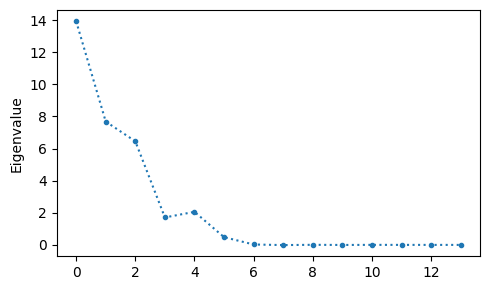

In [14]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

# y = np.array(energy) - e_ground_state_exact
y = np.linalg.eigvals(final_hessian)

# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
ax.plot(y, ".:")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
# ax.set_yscale("log")
ax.set_ylabel("Eigenvalue")
# ax.set_xlabel("Eigenvalue")
# ax.legend()

plt.tight_layout()
plt.show()